In [1]:
import os
from langgraph.graph import END, StateGraph
from typing import Annotated, Callable, Type, Dict
from code_gen.logger import setup_logging, log
from code_gen.code_generator import CodeGenerator, FileStatus
from code_gen.virtual_env_manager import ProjectVirtualEnvironmentManager
from code_gen.graph_state import SharedState
from code_gen.utils import PromptHandler
from code_gen.file_manager import FileGenerator
from code_gen.code_generator import CodeType

# set up logging
setup_logging('INFO')

def generate_baseline_codebase(state: SharedState) -> SharedState:
    """
    Generates baseline code for the given shared state.

    Args:
        state (SharedState): The shared state object.

    Returns:
        SharedState: The updated shared state object with baseline code generated.
    """
    code_generator = CodeGenerator(state=state)
    return code_generator.generate_codebase_multiple_prompts_threaded(codebase_type=CodeType.SOURCE)

def set_up_environment(state: SharedState):
    """
    Set up the environment for the code generation process by creating a virtual environment, generating source files
    from the baseline codebase, creating an INI file, and creating a test configuration file.

    Args:
        state (SharedState): The initial state of the code generation process.

    Returns:
        SharedState: The updated state after setting up the environment.

    Raises:
        ValueError: If the virtual environment setup or test configuration creation fails.
    """
    log("Setting up environment", "INFO")
    venv_manager = ProjectVirtualEnvironmentManager(state=state)
    new_state = venv_manager.create_venv()
    has_cwd_setup = venv_manager.check_venv_setup()
    if has_cwd_setup:
        log("Creating files from baseline codebase", "INFO")
        FileGenerator.create_source_files(new_state)
        FileGenerator.create_ini_file(dir_name='src')
    else:
        raise ValueError("Failed to set up virtual environment.")
    log("Creating test config", "INFO")
    config_path = venv_manager.prompt_settings.config_file_path
    is_config_created = venv_manager.create_test_config(config_path=config_path)
    if not is_config_created:
        raise ValueError("Failed to create test config.")
    log("Environment setup complete", "INFO")
    return new_state

def generate_test_cases(state: SharedState):
    """
    Generate test cases based on the source code using the CodeGenerator, and create test files using the FileGenerator.

    Args:
        state (SharedState): The current state of the code generation process.

    Returns:
        SharedState: The updated state after generating test cases and creating test files.
    """
    code_generator = CodeGenerator(state=state)
    new_state = code_generator.generate_test_from_source_state_threaded()
    FileGenerator.create_test_files(new_state)
    return new_state

def run_tests(state: SharedState):
    """
    Run tests on the source code and test code, check the status of all files, and check test coverage.
    If all tests pass, set the final status or iterate on the main.py file if necessary.

    Args:
        state (SharedState): The current state of the code generation process.

    Returns:
        SharedState: The updated state after running tests and checking coverage.
    """
    test_runner = CodeGenerator(state=state).initialize_test_runner()
    # run tests on source code
    new_state = test_runner.run_tests_on_all_source_files_threaded()
    # run tests on test code
    test_runner = CodeGenerator(state=new_state).initialize_test_runner()
    new_state = test_runner.run_tests_on_all_test_files_threaded()
    # check all file status
    new_state.source_file_status = test_runner.check_status_source_files()
    new_state.test_file_status = test_runner.check_status_test_files()
    all_features_passed = new_state.source_file_status & new_state.test_file_status
    log(f"All tests passed: {all_features_passed}", "INFO")
    # check test coverage
    if not new_state.coverage and (all_features_passed or new_state.iteration_count==state.max_iterations):
        log("Checking Coverage", "INFO")
        new_state = test_runner.check_coverage("tests/")
    # iterate on main.py if all features passed tests
    if all_features_passed and new_state.source_file_states['main'].status == FileStatus.ALL_TESTS_PASSED:
        # set final status
        new_state.all_tests_passed = True
    elif all_features_passed and new_state.source_file_states['main'].status != FileStatus.ALL_TESTS_PASSED:
        new_file_state = test_runner.run_tests_on_file(new_state.source_file_states['main'])
        new_state.source_file_states['main'] = new_file_state
    return new_state

def fix_codes(state: SharedState) -> SharedState:
    """
    Iteratively fix the source code, test code, and main code by generating new code using the CodeGenerator
    and creating new source and test files using the FileGenerator.

    Args:
        state (SharedState): The current state of the code generation process.

    Returns:
        SharedState: The updated state after fixing the source code, test code, and main code.
    """
    state.iteration_count += 1
    code_runner = CodeGenerator(state=state)
    # fix source code
    new_state = code_runner.fix_error_from_source_state_threaded()
    FileGenerator.create_source_files(new_state)
    # fix test code
    code_runner = CodeGenerator(state=new_state)
    new_state = code_runner.fix_error_from_test_state_threaded()
    FileGenerator.create_test_files(new_state)
    if new_state.source_file_status & new_state.test_file_status:
        # fix main code
        code_runner = CodeGenerator(state=new_state)
        new_state = code_runner.fix_error_from_source_state_threaded(specific_files=['main'])
        FileGenerator.create_source_files(new_state)
    return new_state

    
def should_continue(state: SharedState) -> Dict[str, bool]:
    """
    Determines whether the code generation and testing process should continue or end.

    Args:
        state (SharedState): The shared state containing the necessary information to make the decision.

    Returns:
        str: Either "end" to indicate the process should end, or "fix_error" to indicate the process should continue to fix errors.
    """
    log("Checking if code generation and testing should continue", "INFO")
    log("*"*10+f"Iteration_Count {state.iteration_count}, Max Iterations {state.max_iterations}"+"*"*10, "INFO")
    if state.all_tests_passed or state.iteration_count >= state.max_iterations:
        return "end"
    else:
        return "fix_codes"

def visualize_dag(dag: StateGraph):
    """
    Visualizes the StateGraph DAG.

    Args:
        dag (StateGraph): The StateGraph object.
    """
    from IPython.display import Image, display
    from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors
    # build a graph
    app = dag.compile()
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
def build_dag(state_schema: Type[SharedState])-> Callable[[SharedState], SharedState]:
    """
    Creates a workflow using the StateGraph.

    Args:
        state_schema (Annotated[SharedState, str]): The annotated shared state schema.

    Returns:
        Callable[[SharedState], SharedState]: A function that takes a SharedState and returns an updated SharedState after executing the workflow.
    """
    dag = StateGraph(state_schema=Annotated[state_schema, "shared"])

    # add nodes
    dag.add_node('generate_baseline_codebase', generate_baseline_codebase)
    dag.add_node('set_up_environment', set_up_environment)
    dag.add_node('generate_test_cases', generate_test_cases)
    dag.add_node('run_tests', run_tests)
    dag.add_node('fix_codes', fix_codes)
    # # set edges
    dag.set_entry_point('generate_baseline_codebase')
    dag.add_edge('generate_baseline_codebase','set_up_environment')
    dag.add_edge('set_up_environment', 'generate_test_cases')
    dag.add_edge('generate_test_cases', 'run_tests')
    dag.add_conditional_edges(
        "run_tests",
        should_continue,
        {
            "end": END,
            "fix_codes": "fix_codes",
        },
    )
    dag.add_edge('fix_codes', 'run_tests')
    return dag

# ++++++++++++++++++++++++++++++++++++
#       Execute a graph
# ++++++++++++++++++++++++++++++++++++
log("Start of program")

# Store current directory
original_dir = os.getcwd()

# Specify code base for project. 
# Ensure corresponding prompt templates are provided.
baseline_file_names = {
    "preprocess": "preprocess.py",
    "model": "model.py",
    "evaluate": "evaluate.py",
    "inference": "inference.py",
    "main": "main.py",
    "requirements": "requirements.txt"    
}

# Dynamically create test code model based on code base
baseline_test_file_names = {f"{k}": f"{k}" for k, v in baseline_file_names.items() if k not in ['requirements', 'main']}

all_test_passed = False
# specify max retry of entire process
max_dag_retry = 1 
ct = 0

while not all_test_passed and ct < max_dag_retry:
    log(f"Executing DAG {ct}", "INFO")
    # initialze state
    initial_state = SharedState(
        config_path=PromptHandler.resolve_file_path(',', 'params/breast_cancer.yml'),
        baseline_file_names=baseline_file_names,
        baseline_test_file_names=baseline_test_file_names,
        max_iterations=5
    )
    # build a graph
    dag = build_dag(initial_state)
    app = dag.compile()

    # execute a dag
    final_state = app.invoke(initial_state, {"recursion_limit": 50})
    all_test_passed = final_state.all_tests_passed

    # change back to original direcotry
    os.chdir(original_dir)

    # increment counter
    ct += 1

log("End of program")

2024-08-22 08:35:19 - INFO - Start of program
2024-08-22 08:35:19 - INFO - Executing DAG 0
2024-08-22 08:35:19 - INFO - Generating SOURCE codebase (threaded)
2024-08-22 08:35:20 - INFO - Generating code for preprocess
2024-08-22 08:35:20 - INFO - Generating code for model
2024-08-22 08:35:20 - INFO - Generating code for evaluate
2024-08-22 08:35:20 - INFO - Generating code for inference
2024-08-22 08:35:20 - INFO - Generating code for main
2024-08-22 08:35:20 - INFO - Loading cached SSO token for profile-dev
2024-08-22 08:35:34 - INFO - Generating code for requirements
2024-08-22 08:35:58 - INFO - Setting up environment
2024-08-22 08:35:58 - INFO - Creating virtual environment
2024-08-22 08:35:58 - INFO - Script path: /Users/kennysat/Desktop/Projects/VSC/aws_builder/ds-model-codegen-bedrock
2024-08-22 08:35:58 - INFO - Current working directory set to: /Users/kennysat/Desktop/Projects/VSC/aws_builder/ds-model-codegen-bedrock
2024-08-22 08:35:58 - INFO - Changed directory to: /Users/ken

### Test Coverage Result

In [2]:
final_state.coverage

{'metadata': {'format': 3,
  'version': '7.6.1',
  'timestamp': '2024-08-22T10:31:21.300312',
  'branch_coverage': False,
  'show_contexts': False},
 'summary': {'total_statements': 403,
  'covered_statements': 387,
  'missing_statements': 16,
  'percent_covered': 96.02977667493796},
 'files': {'src/evaluate.py': {'num_statements': 29,
   'covered_lines': 27,
   'missing_lines': 2,
   'percent_covered': 93.10344827586206},
  'src/inference.py': {'num_statements': 22,
   'covered_lines': 21,
   'missing_lines': 1,
   'percent_covered': 95.45454545454545},
  'src/model.py': {'num_statements': 42,
   'covered_lines': 32,
   'missing_lines': 10,
   'percent_covered': 76.19047619047619},
  'src/preprocess.py': {'num_statements': 41,
   'covered_lines': 39,
   'missing_lines': 2,
   'percent_covered': 95.1219512195122},
  'tests/test_evaluate.py': {'num_statements': 64,
   'covered_lines': 64,
   'missing_lines': 0,
   'percent_covered': 100.0},
  'tests/test_inference.py': {'num_statements'

### Visualize Graph

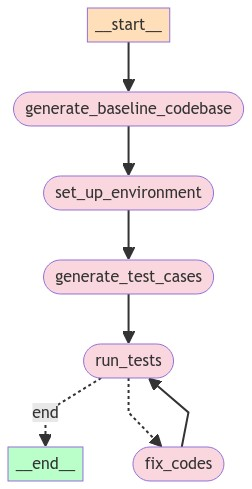

In [ ]:
# visualize the graph
visualize_dag(dag)

#### Check Test Results

In [4]:
from code_gen.utils import PrintTestResultSummary

print_summary = PrintTestResultSummary(final_state)
print_summary.generate_result_summary()

{'Source': {'src/preprocess.py': Status: ALL_TESTS_PASSED
  Iteration Count: 4
  Import Passed: True
  Code Passed: True
  Pytest Passed: True
  Error: ,
  'src/model.py': Status: ALL_TESTS_PASSED
  Iteration Count: 4
  Import Passed: True
  Code Passed: True
  Pytest Passed: True
  Error: ,
  'src/evaluate.py': Status: ALL_TESTS_PASSED
  Iteration Count: 3
  Import Passed: True
  Code Passed: True
  Pytest Passed: True
  Error: ,
  'src/inference.py': Status: ALL_TESTS_PASSED
  Iteration Count: 4
  Import Passed: True
  Code Passed: True
  Pytest Passed: True
  Error: ,
  'main.py': Status: ALL_TESTS_PASSED
  Iteration Count: 1
  Import Passed: True
  Code Passed: True
  Pytest Passed: True
  Error: ,
  'requirements.txt': Status: IMPORT_TEST_PENDING
  Iteration Count: 1
  Import Passed: False
  Code Passed: False
  Pytest Passed: False
  Error: },
 'Pytest': {'tests/test_evaluate.py': Status: ALL_TESTS_PASSED
  Iteration Count: 3
  Import Passed: True
  Code Passed: True
  Pytest Pas